# Tarea 2 MA-5701

Integrantes:

    - Sebastian Lopez
    - Kurt Walsen
    - Francisco Vásquez

# Previos

## Importación de Librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as tick
import gurobipy as gb
import scipy.optimize as opti

from sklearn.metrics import mean_squared_error

## Parámetros Generales

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)

# Parámetros para gráficos
plt.style.use('seaborn')

plt.rcParams.update({'font.size': 25})      
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)  
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.titlesize'] = 25
plt.rcParams["figure.figsize"] = (15,6)

# Trabajo de Datos

## Importación

In [3]:
df = pd.read_csv('data/data_modificada.csv')

## Trabajo previo

In [4]:
df.head()

,Fecha,Dia,Casos Totales,Recuperados,Fallecidos,Removidos
0,3/3/2020,1,1,0,0,0
1,3/4/2020,2,3,0,0,0
2,3/5/2020,3,4,0,0,0
3,3/6/2020,4,5,0,0,0
4,3/7/2020,5,7,0,0,0


In [5]:
df.Fecha = pd.to_datetime(df.Fecha)
df = df.sort_values(by = 'Fecha')

# Visualizaciones

In [6]:
def plot_columna(columna):
    data = df.set_index('Fecha')[columna]
    
    fig, ax = plt.subplots()
    
    grafico = data.plot(kind = 'line', ax = ax,
                       style = '.-', linewidth = 2,
                       ms = 10)
    
    plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Fecha')
    
    plt.title('Cantidad de {} por Fecha'.format(columna))
    plt.tight_layout()
    plt.savefig('graficos/graf_cantidad_{}_fecha.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)
    plt.show()

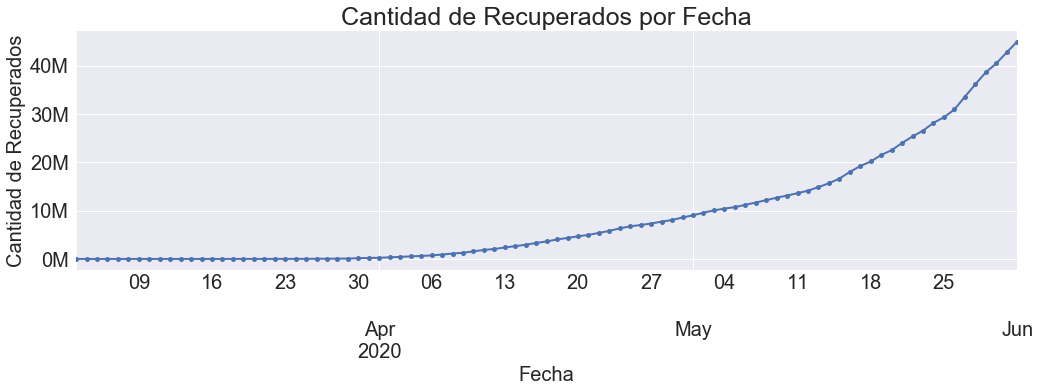

In [7]:
plot_columna('Recuperados')

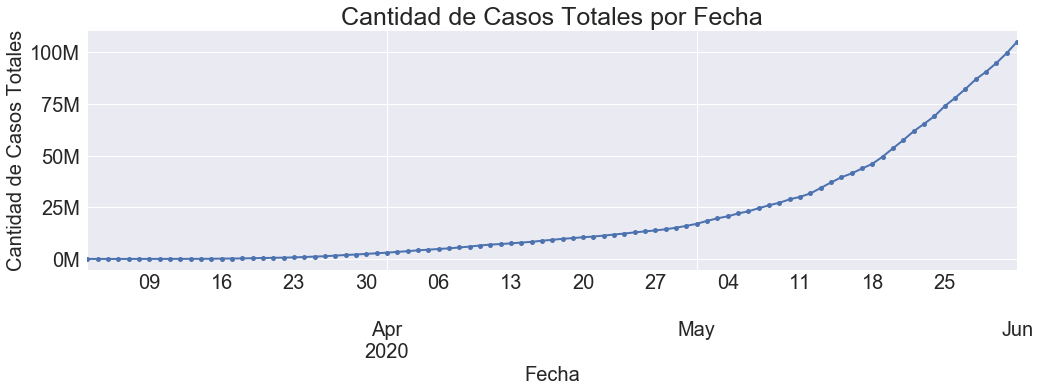

In [8]:
plot_columna('Casos Totales')

# Modelo

## Modelo Infectados General

In [9]:
def func_to_optimize_infectados(params):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    val = 0
    
    for dia, n_infectados in enumerate(df['Casos Totales']):
        logit = (alpha)/(1 + beta * np.exp(-dia / sigma))
        val = val + np.power(n_infectados - logit, 2)
    
    return val

In [10]:
bnds_infectados = ((0, None), (0, None), (0, None))

x0_infectados_general = [1000000., 200., 10.]

In [11]:
mod_infectados_general = opti.minimize(fun = func_to_optimize_infectados,
                                       x0 = x0_infectados_general,
                                       bounds = bnds_infectados)

## Modelo Infectados Máximo 250M

In [12]:
constraints_infectados = (
#                             {'type': 'ineq',
#                            'fun': lambda param: -param[0] + 250000 }
                          {'type': 'eq',
                           'fun': lambda param: param[0] - 250000}
                         )

x0_infectados_cota = [250000., 1000., 1000.]
# x0_infectados_cota = [2500000., 10000., 2000.]
mod_infectados_cota = opti.minimize(fun = func_to_optimize_infectados,
                               x0 = x0_infectados_cota,
                               constraints = constraints_infectados,
                                    bounds = bnds_infectados)

## Modelo Fallecidos General

In [13]:
def func_to_optimize_fallecidos(params):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    val = 0
    
    for dia, n_infectados in enumerate(df['Fallecidos']):
        logit = (alpha)/(1 + beta * np.exp(-dia / sigma))
        val = val + np.power(n_infectados - logit, 2)
    
    return val

In [14]:
constraints_fallecidos = (#{'type': 'ineq',
               #'fun': lambda param: param[0]... >= 0},
              {'type': 'eq',
               'fun': lambda param: param[0] - 250000})
        
bnds_fallecidos = ((0, None), (0, None), (0, None))

x0_fallecidos_general = [1500., 50., 20.]

In [15]:
mod_fallecidos_general = opti.minimize(fun = func_to_optimize_fallecidos,
                                       x0 = x0_fallecidos_general,
                                       bounds = bnds_fallecidos)

# Resultados

## Auxiliar Predicciones

In [16]:
def predicciones(params, vec_dias):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    
    fun = lambda t: (alpha)/(1 + beta * np.exp(-t / sigma))
    
    return list(map(fun, vec_dias))

In [17]:
def plot_diferencias(columna, predicciones, extra = False):
    dia = df['Dia']
    original = df[columna]
    
    fig, ax = plt.subplots()
    
    grafico_real = plt.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                              c = 'green')
    
    grafico_predicciones = plt.plot(dia, predicciones, label = 'Predicción', c = 'royalblue')
    
    if columna == 'Fallecidos':
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Día')
    
    plt.legend(loc=2)
    plt.tight_layout()
    
    if extra:
        plt.title('Predicción de {} por día, Máximo 250M'.format(columna))
        plt.savefig('graficos/graf_prediccion_{}_dia_250M.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)      
    else:
        plt.title('Predicción de {} por día'.format(columna))
        plt.savefig('graficos/graf_prediccion_{}_dia.pdf'.format(columna.replace(' ','')),
               format = 'pdf',
               dpi = 600)
    plt.show()

In [18]:
def pred_largo_plazo(params, dias, columna, extra = False):
    # Generar predicciones
    pred = predicciones(params, range(1,dias+1))
    
    dia = df['Dia']
    original = df[columna]
    
    fig, ax = plt.subplots()
    
    grafico_real = plt.scatter(dia, original, alpha = 0.8, s = 15, label = '{} Real'.format(columna),
                              c = 'green')
    
    
    grafico_predicciones = plt.plot(range(1, dias+1), pred, label = 'Predicción', c = 'royalblue')
    
    
    if columna == 'Fallecidos':
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x)) ))
    else:
        plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: str(int(x//1000)) + 'M' ))
    
    ax.set_ylabel('Cantidad de {}'.format(columna))
    ax.set_xlabel('Día')
    
    plt.legend(loc=2)
    plt.tight_layout()
    
    if extra:
        plt.title('Predicción de {} a {} dias, Máximo 250M'.format(columna, dias))
        plt.savefig('graficos/graf_prediccion_{}_a_{}_dias_250M.pdf'.format(columna.replace(' ',''), dias),
                   format = 'pdf',
                   dpi = 600)
    else:
        plt.title('Predicción de {} a {} dias'.format(columna, dias))
        plt.savefig('graficos/graf_prediccion_{}_a_{}_dias.pdf'.format(columna.replace(' ',''), dias),
                   format = 'pdf',
                   dpi = 600)
    plt.show()

## Predicciones Infectados General

In [19]:
print('Parámetros encontrados:\n Lambda: {} \n Beta: {} \n Sigma: {}'.format(mod_infectados_general.x[0],
                                                                            mod_infectados_general.x[1],
                                                                            mod_infectados_general.x[2]))

Parámetros encontrados:
 Lambda: 999998.8284230591 
 Beta: 2088.9051507919426 
 Sigma: 16.312811899636863


In [20]:
# Prediccion con los parámetros obtenidos de mod_infectados
total_pred = predicciones(mod_infectados_general.x, df['Dia'])

In [21]:
rmse_infectados = np.sqrt(mean_squared_error(df['Casos Totales'], total_pred))
print('El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(rmse_infectados))

El RMSE obtenido con las predicciones es de
 RMSE: 2255.2897691436992


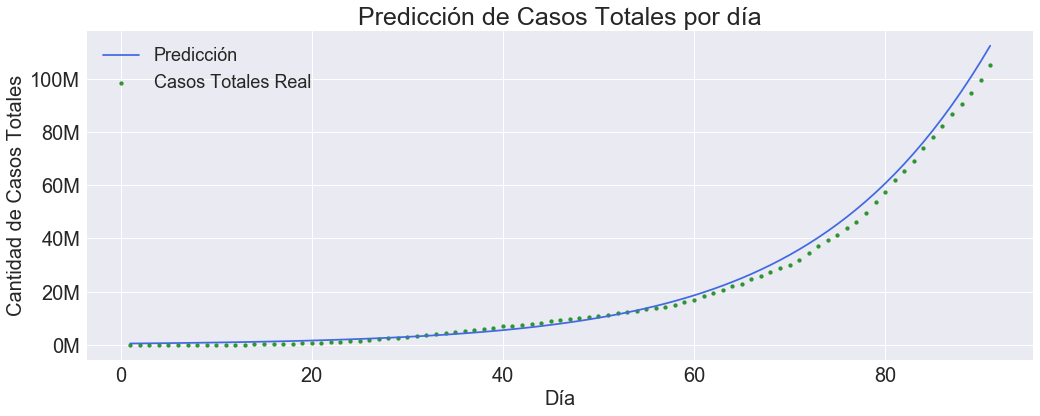

In [22]:
plot_diferencias('Casos Totales', total_pred)

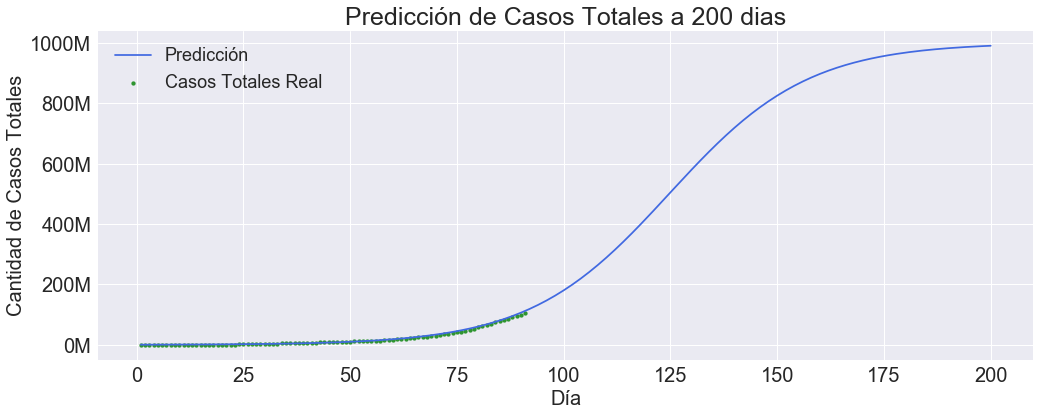

In [23]:
pred_largo_plazo(mod_infectados_general.x, 200, 'Casos Totales')

## Predicciones Infectados Cota

In [24]:
print('Parámetros encontrados:\n Lambda: {} \n Beta: {} \n Sigma: {}'.format(mod_infectados_cota.x[0],
                                                                            mod_infectados_cota.x[1],
                                                                            mod_infectados_cota.x[2]))

Parámetros encontrados:
 Lambda: 250000.0 
 Beta: 258.8339865396042 
 Sigma: 18.642199635383015


In [25]:
# Prediccion con los parámetros obtenidos de mod_infectados
total_pred_cota = predicciones(mod_infectados_cota.x, df['Dia'])

In [26]:
rmse_infectados_cota = np.sqrt(mean_squared_error(df['Casos Totales'], total_pred_cota))
print('El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(rmse_infectados_cota))

El RMSE obtenido con las predicciones es de
 RMSE: 5297.240755134273


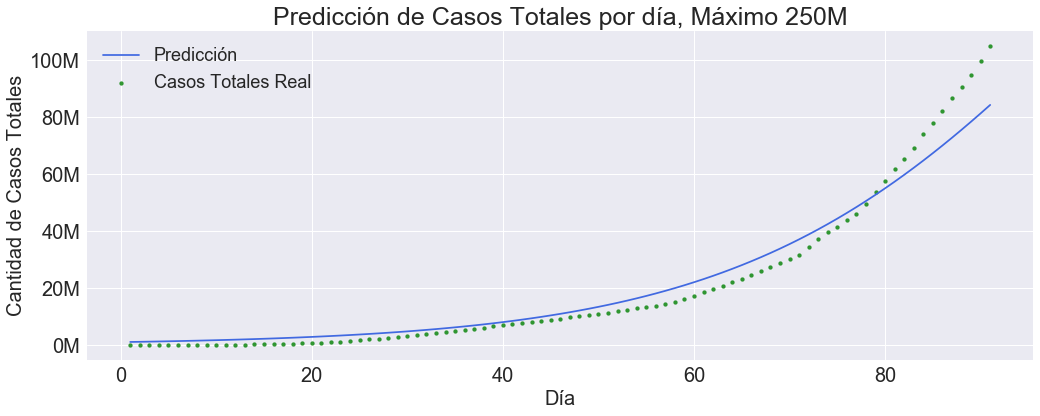

In [27]:
plot_diferencias('Casos Totales', total_pred_cota, extra = True)

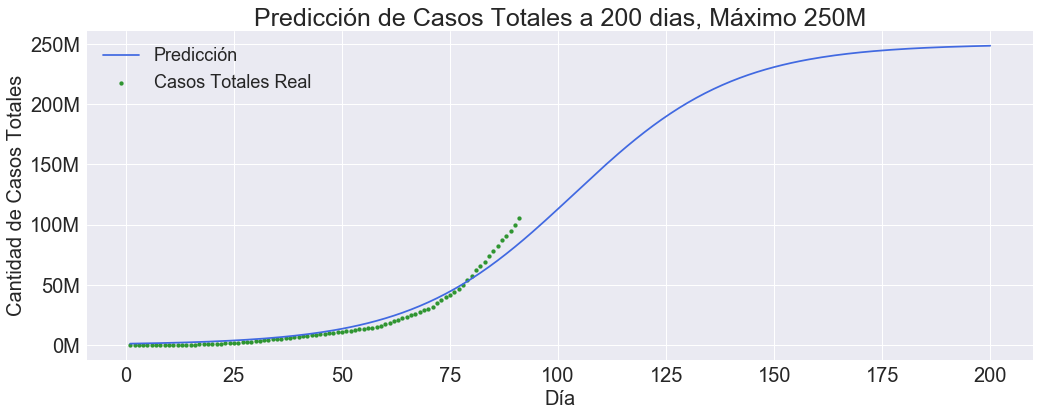

In [28]:
pred_largo_plazo(mod_infectados_cota.x, 200, 'Casos Totales', extra = True)

## Predicciones Fallecidos

In [29]:
print('Parámetros encontrados:\n Lambda: {} \n Beta: {} \n Sigma: {}'.format(mod_fallecidos_general.x[0],
                                                                            mod_fallecidos_general.x[1],
                                                                            mod_fallecidos_general.x[2]))

Parámetros encontrados:
 Lambda: 533535.0235124265 
 Beta: 66786.8636173794 
 Sigma: 18.267558299014826


In [30]:
# Prediccion con los parámetros obtenidos de mod_fallecidos
fallecidos_pred = predicciones(mod_fallecidos_general.x, df['Dia'])

In [31]:
rmse_fallecidos = np.sqrt(mean_squared_error(df['Fallecidos'], fallecidos_pred))
print('El RMSE obtenido con las predicciones es de\n RMSE: {}'.format(rmse_fallecidos))

El RMSE obtenido con las predicciones es de
 RMSE: 30.57260034941869


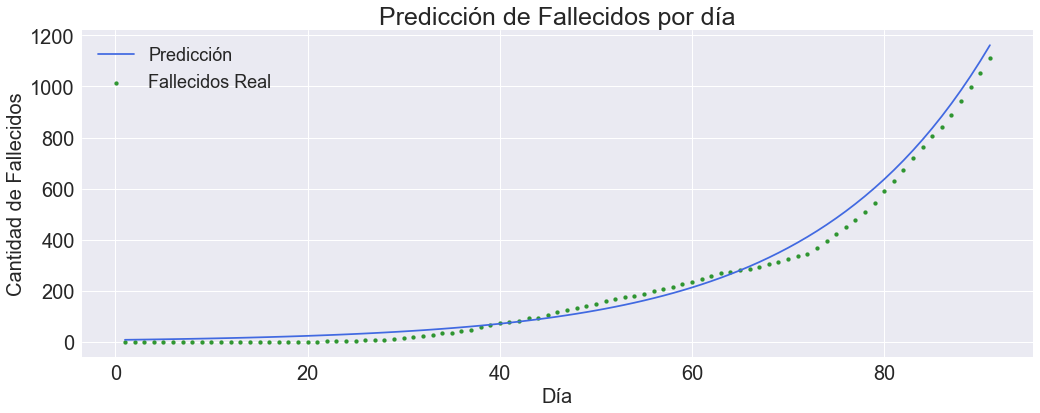

In [32]:
plot_diferencias('Fallecidos', fallecidos_pred)

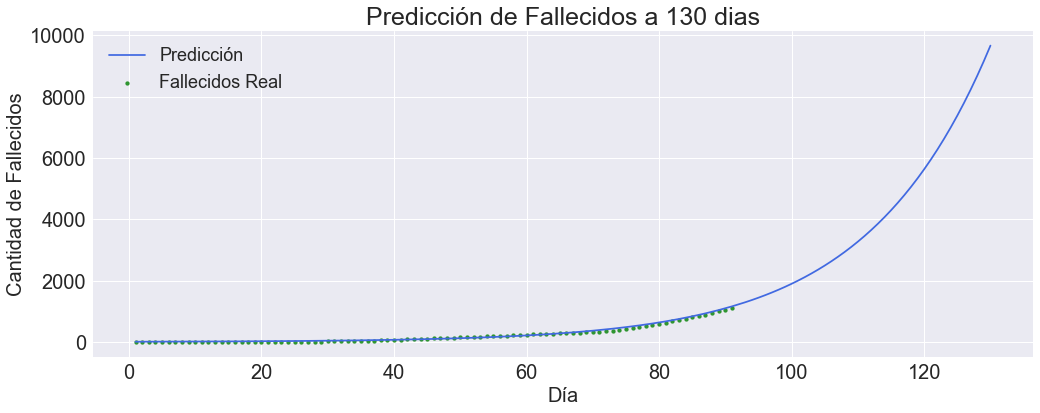

In [33]:
pred_largo_plazo(mod_fallecidos_general.x, 130, 'Fallecidos')